# ML Project - Predicting Bad Cases - Sprint 2
    19-04-23 15:19
    Edward Sims
    Credit Team



## Introduction
The aim of this project is to attempt to predict bad cases using the Lender data. The deliverables of this project are not only to predict the bad cases themselves, but also to see which features are most important in making these predictions. 

In the previous sprint 1, we achieved an accuracy of 96% and a recall of 11%. The main objective of sprint 2 is to boost the recall value as much as possible, to be able to provide more meaningful results.

Bad cases in this project are considered to be any loan reference that is in arrears of over 30 days.

The Lender Portal download will be used as our dataset for the time being. 

High level aims of the project are to then take the results of the predictors and use them to help fine tune the Decision Engine.


## Exploratory Data Analysis
The goal of this section is to gain an understanding of our data in order to inform what we do in the feature engineering section.

We begin our exploratory data analysis by loading our standard modules. We then proceed to do some initial tidying of our data before looking at the features one by one. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import ipaddress
from datetime import date
import datetime as dt
from pandas.tseries.offsets import BMonthEnd
import gc
import os

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve
from sklearn.utils.multiclass import unique_labels

C:\Users\Edward Sims\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We then load the data, which we have downloaded from duoBI.

In [2]:
lender_data_raw = pd.read_csv('input/Lender_Raw_Data.csv')
print("Raw data shape: " + str(lender_data_raw.shape))

# Only select Activated, Accepted and Signed cases
print("Removed " + str(len(lender_data_raw[~((lender_data_raw['Status.1'] == 'ACTIVATED') | (lender_data_raw['Status.1'] == 'ACCEPTED') | (lender_data_raw['Status.1'] == 'SIGNED'))])) + " records that were not activated, accepted or signed.")
lender_data = lender_data_raw[(lender_data_raw['Status.1'] == 'ACTIVATED') | (lender_data_raw['Status.1'] == 'ACCEPTED') | (lender_data_raw['Status.1'] == 'SIGNED')]

Raw data shape: (80749, 90)
Removed 49588 records that were not activated, accepted or signed.


In [3]:
lender_data.shape

(31161, 90)

Next we need to upload a Multi-tier dataset to match records by.

In [4]:
mtier_data = pd.read_csv('input/mtier 19-04-12.csv')
lender_data['mtier'] = pd.Series(lender_data['LoanRef'].isin(mtier_data['AgreementRef']).astype(int))
print(str(sum(lender_data['mtier'])) + " m-tier records")

1136 m-tier records


C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We then remove all records that are too young to have arrears. As payments are made monthly, the minimum arrears possible is one month, meaning any application younger than a month is pointless.

In [5]:
print("Removed " + str(sum((date.today() - pd.to_datetime(lender_data['CreatedAt'], format='%Y-%m-%d %H:%M:%S').dt.date) < "91 days")) + " records under 91 days old")
lender_data = lender_data[~((date.today() - pd.to_datetime(lender_data['CreatedAt'], format='%Y-%m-%d %H:%M:%S').dt.date) < "91 days")]

Removed 9158 records under 91 days old


Now we've done our initial data work, we upload our arrears data to get labels from. This is the full historic dataset of all loans gone bad at each month end, so includes duplicated Loan References (for loans that have remained bad over the months). We'll remove duplicate loan references, retaining records with the bad case label. We'll also make sure to save the arrears dataset WITH duplicates for future use in the oversampling section.

In [6]:
# Import Arrears data
arrears_data = pd.read_csv('input/arrears_history.csv',
                           #engine = 'python', # Only need to use this for the skipfooter arg
                           skiprows = 1,
                           #skipfooter = 3,
                           thousands = ',', # Recognise thousand separator
                           decimal = '.', # Recognise decimal point
                           usecols = [3,7,8,9,10,11,12],
                           names = ['LoanRef','1-30','31-60','61-90','91-180','181-270','271-365']
                          )

In [7]:
def map_bad_case(row):
    """
    Map the arrears columns to our bad case labels
    """
    if row['31-60'] > 12:
        val = 1
    elif row['61-90'] > 12:
        val = 1
    elif row['91-180'] > 12:
        val = 1
    elif row['181-270'] > 12:
        val = 1
    elif row['271-365'] > 12:
        val = 1
    else:
        val = 0
    return val

In [8]:
# Map arrears data to bad case label
arrears_data['bad_case'] = arrears_data.apply(map_bad_case, axis = 1)

In [9]:
# Subset arrears_data to only bad cases
arrears_data_with_dupes = arrears_data[arrears_data['bad_case'] == 1]

In [10]:
# Subset arrears_data to just LoanRef and labels, and save 
arrears_data_no_dupes = arrears_data_with_dupes.drop_duplicates('LoanRef')
arrears_data_no_dupes = arrears_data_no_dupes.iloc[:, [0,7]]

print("Number of arrears bad cases: " + str(len(arrears_data_no_dupes)) + " (Unique records)")

Number of arrears bad cases: 1569 (Unique records)


In [11]:
df = lender_data.merge(arrears_data_no_dupes, on='LoanRef', how='left')
df['bad_case'].fillna(0, inplace = True)

In [12]:
print("arrears data bad cases: " + str(len(arrears_data_no_dupes)))

print("df records: " + str(len(df)))
print("df bad cases: " + str(sum(df['bad_case'])) + "  //  " + str(sum(df['bad_case'])/len(df)))

arrears data bad cases: 1569
df records: 22003
df bad cases: 1380.0  //  0.06271872017452165


In [13]:
# Save the datasets so far
df.to_csv('df_before_feature_engineering.csv')
arrears_data_no_dupes.to_csv('final_arrears_data.csv')

First, let's take a look at the shape and summary of all the data. Immediately, we note that several features have nulls that we'll have to deal with.

In [14]:
df.shape

(22003, 92)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22003 entries, 0 to 22002
Data columns (total 92 columns):
ApplicationID                         22003 non-null object
ActiveCAIS3Applicant                  21826 non-null object
ActiveCAIS3AssociateID                10197 non-null object
ApplicantinIVA                        21844 non-null object
BankClosedWarning                     21898 non-null object
BankEnhancedScore                     0 non-null float64
BankruptcyInformationApplicant        21844 non-null float64
BankruptcyInformationAssociate        10844 non-null float64
CAISSpecialInstructionSet             21774 non-null object
ConfirmatoryDobs                      21889 non-null float64
ConfirmedOnVotersRoll                 21845 non-null object
CreditScore                           21845 non-null float64
DeceasedWarning                       21897 non-null object
DefaultCAISApplicant                  21844 non-null object
DefaultCAISAssociate                  2530 non-nul

It appears that we can drop all the ID features as these will be useless*. We've removed all empty features too. 

We've also removed the Status columns, as we've already filtered them to only show Activated records, as well as any other features that are rendered void since this filter. 

**We've kept the LoanRef field just for later use in oversampling.*

In [16]:
cols_remove = ['BankEnhancedScore','DeviceRisk','HasactivePaydayLoan','Householdincome','JudgementApplicant', 
               'JudgementAssociate','NumberofBankruptcies','MerchantSector','Nationality','ApplicationID',
               'Status', 'Status.1','StatusBriefing','MerchantID','DeclinedAt','InfoNeededAt',
                'DepositPaidAt', 'FinanceID', 'Reference', 'ActivatedAt', 'SignedAt', 'LoanRef',
               'AwaitingActivationAt','AddedToWatchlist','PGVariable','AddedToWatchlist','Comments'
              ]
df = df.drop(cols_remove, 1)

### Bad Cases
We need to add labels to our dataset for the Bad Cases. A 1 will signify a Bad Case, and a 0 will signify all others. 

In [17]:
df.bad_case.value_counts(normalize=True)

0.0    0.937281
1.0    0.062719
Name: bad_case, dtype: float64

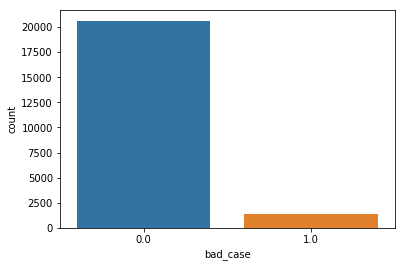

In [18]:
sns.countplot(df.bad_case)
plt.show()

As expected, the data is really skewed towards the non-bad cases. We'll need to figure out the best way to fix this. 

### ActiveCAIS3Applicant
This variable is in part numerical. We'll need to map the Default (D) and Unknown (U) cases into numerical values. Looks like there is some useful information to be extracted here in terms of bad cases - higher numbers of D values have bad cases than others. We'll map D = 10, and U = 0.

In [19]:
print('bad_case summarised for each ActiveCAIS3Applicant')
df.bad_case.groupby(df.ActiveCAIS3Applicant).agg(['mean', 'count'])

bad_case summarised for each ActiveCAIS3Applicant


,mean,count
ActiveCAIS3Applicant,,
0,0.050136,3690
1,0.057650,3608
2,0.110756,939
3,0.086111,360
4,0.098765,162
5,0.060000,100
6,0.096774,248
D,0.202696,2077
U,0.035050,10642


NaNs will be considered U, as as far as I'm concerned they are the same thing.

In [20]:
df['ActiveCAIS3Applicant'].fillna('U', inplace = True)

In [234]:
# Replace 'D' values with 10
df.loc[df.ActiveCAIS3Applicant == 'D', 'ActiveCAIS3Applicant'] = 10

SyntaxError: EOL while scanning string literal (<ipython-input-234-522f16557d2a>, line 2)

In [ ]:
# Replace 'U' values with 0
df.loc[df.ActiveCAIS3Applicant == 'U', 'ActiveCAIS3Applicant'] = 0

In [23]:
# Make col numeric
df['ActiveCAIS3Applicant'] = pd.to_numeric(df['ActiveCAIS3Applicant'])

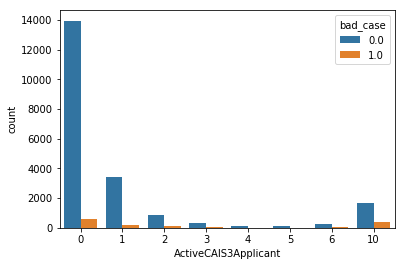

In [24]:
sns.countplot(df['ActiveCAIS3Applicant'], hue = df['bad_case'])

### ActiveCAIS3AssociateID
Similar to ActiveCAIS3Applicant - we'll need to map the Default (D) and Unknown (U) cases into 10 and 0. 

In [25]:
print('bad_case summarised for each ActiveCAIS3AssociateID')
df.bad_case.groupby(df.ActiveCAIS3AssociateID).agg(['mean', 'count'])

bad_case summarised for each ActiveCAIS3AssociateID


,mean,count
ActiveCAIS3AssociateID,,
0,0.026033,2420
1,0.032600,1319
2,0.061433,293
3,0.090226,133
4,0.081967,61
5,0.090909,44
6,0.067227,119
D,0.114010,1035
U,0.020113,4773


NaNs will again be considered U.

In [26]:
df['ActiveCAIS3AssociateID'].fillna('U', inplace = True)

In [27]:
# Replace 'D' values with 10
df.loc[df.ActiveCAIS3AssociateID == 'D', 'ActiveCAIS3AssociateID'] = 10

In [28]:
# Replace 'U' values with 0
df.loc[df.ActiveCAIS3AssociateID == 'U', 'ActiveCAIS3AssociateID'] = 0

In [29]:
# Make col numeric
df['ActiveCAIS3AssociateID'] = pd.to_numeric(df['ActiveCAIS3AssociateID'])

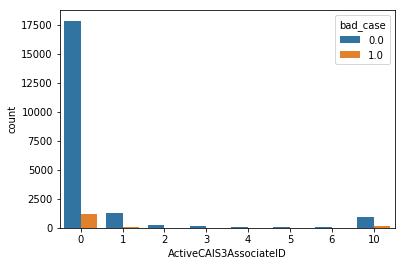

In [30]:
sns.countplot(df['ActiveCAIS3AssociateID'], hue = df['bad_case'])

### ApplicantinIVA
This feature doesn't seem to be too useful given that all records but 116 are False, and there are currently no True values. We'll get rid of this one. 

In [31]:
df.bad_case.groupby(df.ApplicantinIVA).agg(['mean', 'count'])

,mean,count
ApplicantinIVA,,
False,0.062809,21844


In [32]:
print('Count of NaNs: ',df['ApplicantinIVA'].isna().sum())

Count of NaNs:  159


In [33]:
cols_remove_2 = ['ApplicantinIVA']

### BankClosedWarning
Sparse feature - we'll get rid of this. 

In [34]:
df.bad_case.groupby(df.BankClosedWarning).agg(['mean', 'count'])

,mean,count
BankClosedWarning,,
False,0.062745,21898


In [35]:
print('Count of NaNs: ',df['BankClosedWarning'].isna().sum())

Count of NaNs:  105


In [36]:
cols_remove_2.append('BankClosedWarning')

### BankruptcyInformationApplicant
Sparse feature - makes sense as we are very unlikely to be lending to people who have had bankrupcies. We'll get rid of this feature. 

In [37]:
df.bad_case.groupby(df.BankruptcyInformationApplicant).agg(['mean', 'count'])

,mean,count
BankruptcyInformationApplicant,,
0.0,0.062809,21844


In [38]:
print('Count of NaNs: ',df['BankruptcyInformationApplicant'].isna().sum())

Count of NaNs:  159


In [39]:
cols_remove_2.append('BankruptcyInformationApplicant')

### BankruptcyInformationAssociate
This is an interesting variable - There is potential use in keeping this feature as there are so many more bad cases for NaN records that for others. We will engineer the feature to be `is_BankruptcyInformationAssociate` and map to 0 = False, 1 = Unknown, 2 = True.

In [40]:
df['bad_case'].groupby(df['BankruptcyInformationAssociate'].isnull()).mean()

BankruptcyInformationAssociate
False    0.036795
True     0.087911
Name: bad_case, dtype: float64

In [41]:
df.bad_case.groupby(df.BankruptcyInformationAssociate).agg(['mean', 'count'])

,mean,count
BankruptcyInformationAssociate,,
0.0,0.036326,10736
1.0,0.084906,106
2.0,0.000000,2


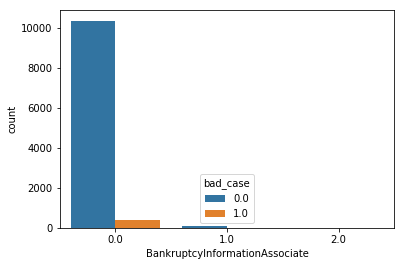

In [42]:
sns.countplot(df['BankruptcyInformationAssociate'], hue = df['bad_case'])

### CAISSpecialInstructionSet
Sparse feature - we'll get rid of this.

In [43]:
df.bad_case.groupby(df.CAISSpecialInstructionSet).agg(['mean', 'count'])

,mean,count
CAISSpecialInstructionSet,,
G,0.000000,1
N,0.062003,21773


In [44]:
print('Count of NaNs: ',df['CAISSpecialInstructionSet'].isna().sum())

Count of NaNs:  229


In [45]:
cols_remove_2.append('CAISSpecialInstructionSet')

### ConfirmatoryDobs
Quite normally distributed, and a noticeable amount of bad cases for NaN values. We will make a null_flag feature for this. 

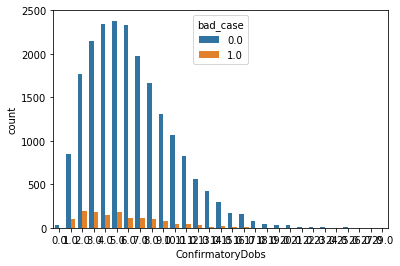

In [46]:
sns.countplot(df['ConfirmatoryDobs'], hue = df['bad_case'])

In [47]:
df.bad_case.groupby(df.ConfirmatoryDobs).agg(['mean', 'count'])

,mean,count
ConfirmatoryDobs,,
0.0,0.062500,32
1.0,0.106653,947
2.0,0.096262,1953
3.0,0.076329,2332
4.0,0.057615,2482
5.0,0.070258,2562
6.0,0.047794,2448
7.0,0.051467,2079
8.0,0.056818,1760


In [48]:
df['bad_case'].groupby(df['ConfirmatoryDobs'].isnull()).agg(['mean', 'count'])

,mean,count
ConfirmatoryDobs,,
False,0.062771,21889
True,0.052632,114


### ConfirmedOnVotersRoll
This feature seems overall pretty useless - we'll get rid of this one. 

In [49]:
df.bad_case.groupby(df.ConfirmedOnVotersRoll).agg(['mean', 'count'])

,mean,count
ConfirmedOnVotersRoll,,
I1,0.062818,21841
I2,0.000000,3
S1,0.000000,1


In [50]:
print('Count of NaNs: ',df['ConfirmedOnVotersRoll'].isna().sum())

Count of NaNs:  158


In [51]:
cols_remove_2.append('ConfirmedOnVotersRoll')

### CreditScore
A really useful indicator. There are 115 nulls for CreditScore, and they interestingly have a lower bad case rate than the non-nulls. Before imputing values for the nulls, we will include a CreditScoreNull flag just to make sure we can account for this characteristic of the data.

In [52]:
print('Count of NaNs: ',df['CreditScore'].isnull().sum())

Count of NaNs:  158


In [53]:
df['bad_case'].groupby(df['CreditScore'].isnull()).agg(['mean', 'count'])

,mean,count
CreditScore,,
False,0.062806,21845
True,0.050633,158


In [54]:
df['bad_case'].groupby(pd.qcut(df['CreditScore'],5)).mean()

CreditScore
(500.999, 584.0]    0.181300
(584.0, 616.0]      0.060063
(616.0, 644.0]      0.036944
(644.0, 671.0]      0.019205
(671.0, 731.0]      0.015341
Name: bad_case, dtype: float64

In [55]:
pd.qcut(df['CreditScore'],5).value_counts()

(644.0, 671.0]      4426
(584.0, 616.0]      4412
(616.0, 644.0]      4385
(500.999, 584.0]    4385
(671.0, 731.0]      4237
Name: CreditScore, dtype: int64

### DeceasedWarning
Sparse feature - we'll remove this. 

In [56]:
df.bad_case.groupby(df.DeceasedWarning).agg(['mean', 'count'])

,mean,count
DeceasedWarning,,
False,0.062751,21896
True,0.000000,1


In [57]:
print('Count of NaNs: ',df['DeceasedWarning'].isna().sum())

Count of NaNs:  106


In [58]:
cols_remove_2.append('DeceasedWarning')

### DefaultCAISApplicant
This is a useful feature - NaNs and U values mapped to 0 and D mapped to 10.

In [59]:
df.bad_case.groupby(df.DefaultCAISApplicant).agg(['mean', 'count'])

,mean,count
DefaultCAISApplicant,,
0,0.053864,4827
1,0.124343,571
2,0.178378,185
3,0.120000,75
4,0.137255,51
5,0.129032,31
6,0.113208,106
D,0.163587,2922
U,0.038085,13076


In [60]:
print('Count of NaNs: ',df['DefaultCAISApplicant'].isna().sum())

Count of NaNs:  159


In [61]:
df['DefaultCAISApplicant'].fillna('U', inplace = True)

In [62]:
# Replace 'D' values with 10
df.loc[df.DefaultCAISApplicant == 'D', 'DefaultCAISApplicant'] = 10

In [63]:
# Replace 'U' values with 0
df.loc[df.DefaultCAISApplicant == 'U', 'DefaultCAISApplicant'] = 0

In [64]:
# Make col numeric
df['DefaultCAISApplicant'] = pd.to_numeric(df['DefaultCAISApplicant'])

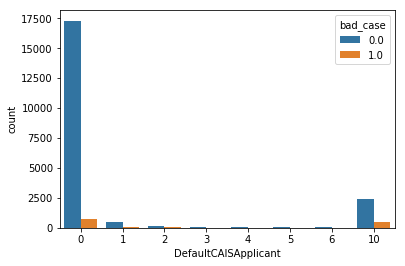

In [65]:
sns.countplot(df['DefaultCAISApplicant'], hue = df['bad_case'])

### DefaultCAISAssociate
There's too little data in this feature. We'll remove this one.

In [66]:
df.bad_case.groupby(df.DefaultCAISAssociate).agg(['mean', 'count'])

,mean,count
DefaultCAISAssociate,,
0,0.040127,947
1,0.090909,22
2,0.000000,12
3,0.000000,7
4,0.000000,7
6,0.000000,12
D,0.103659,328
U,0.044351,1195


In [67]:
print('Count of NaNs: ',df['DefaultCAISAssociate'].isna().sum())

Count of NaNs:  19473


In [68]:
cols_remove_2.append('DefaultCAISAssociate')

### EmailCreated
If this feature was less sparse, we could create a useful feature out of it - such as how long the email has been created for. But we're going to get rid of it as it is too sparse.

In [69]:
print('Count of NaNs: ',df['EmailCreated'].isna().sum())

Count of NaNs:  20625


In [70]:
cols_remove_2.append('EmailCreated')

### EmailDomainStatusIsActive
Some useful stuff here - we'll keep this variable. NaNs have been mapped to Unknown. We'll create an ordinal scale here for Active = 2, Unknown = 1 and Inactive = 0.

In [71]:
df['EmailDomainStatusIsActive'].fillna('Unknown', inplace = True)

In [72]:
df.bad_case.groupby(df.EmailDomainStatusIsActive).agg(['mean', 'count'])

,mean,count
EmailDomainStatusIsActive,,
Active,0.062694,21629
Inactive,0.045455,44
Unknown,0.066667,330


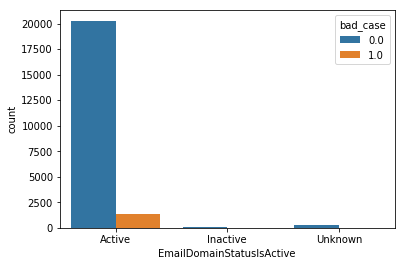

In [73]:
sns.countplot(df['EmailDomainStatusIsActive'], hue = df['bad_case'])

### EmailStatusisActive
We've mapped Expired to Inactive and NaNs to Unknown. We'll create an ordinal scale for this feature where Active = 2, Unknown = 1 and Inactive = 0.

In [74]:
df['EmailStatusisActive'].fillna('Unknown', inplace = True)

In [75]:
df.loc[df.EmailStatusisActive == 'Expired', 'EmailStatusisActive'] = 'Inactive'

In [76]:
df.bad_case.groupby(df.EmailStatusisActive).agg(['mean', 'count'])

,mean,count
EmailStatusisActive,,
Active,0.063203,20711
Inactive,0.074074,108
Unknown,0.053209,1184


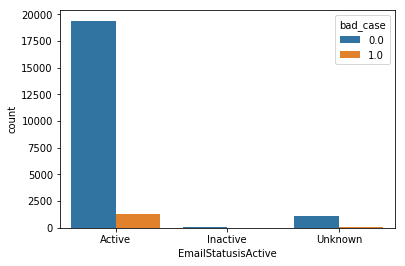

In [77]:
sns.countplot(df['EmailStatusisActive'], hue = df['bad_case'])

### EmailageScore
Looks like it could be a really useful indicator I think - we'll divide the values by ten and round just so it scales better. There are some nulls in there that we'll need to impute, but we should definitely create a null_flag for the feature.

In [78]:
print('Count of NaNs: ',df['EmailageScore'].isna().sum())

Count of NaNs:  321


In [79]:
df['bad_case'].groupby(df['EmailageScore'].isnull()).agg(['mean', 'count'])

,mean,count
EmailageScore,,
False,0.062633,21682
True,0.068536,321


In [80]:
df['bad_case'].groupby(pd.qcut(df['EmailageScore'],5)).mean()

EmailageScore
(18.999, 78.0]    0.042269
(78.0, 94.0]      0.047409
(94.0, 145.0]     0.059081
(145.0, 244.0]    0.069600
(244.0, 906.0]    0.095238
Name: bad_case, dtype: float64

In [81]:
pd.qcut(df['EmailageScore'],5).value_counts()

(18.999, 78.0]    4424
(94.0, 145.0]     4333
(244.0, 906.0]    4326
(78.0, 94.0]      4303
(145.0, 244.0]    4296
Name: EmailageScore, dtype: int64

### EmploymentStatus
A really useful feature. We'll one hot encode this.

In [82]:
df.bad_case.groupby(df.EmploymentStatus).agg(['mean', 'count'])

,mean,count
EmploymentStatus,,
armed_forces,0.000000,32
benefits,0.171233,438
full_time,0.058548,16004
house_person,0.149856,347
part_time,0.075926,540
retired,0.036959,1894
self_employed,0.071045,2604
student,0.138462,130
temporary_employment,0.142857,14


### Gender
Could be useful, we'll one-hot encode this feature.

In [83]:
df.bad_case.groupby(df.Gender).agg(['mean', 'count'])

,mean,count
Gender,,
female,0.059734,10664
male,0.065526,11339


### GrossIncome
Obviously will be a useful feature. We'll log transform this for better performance.

`fcc_survey_df['Income_log'] = np.log((1+ fcc_survey_df['Income'])`

`income_log_mean = np.round(np.mean(fcc_survey_df['Income_log']), 2)
fig, ax = plt.subplots()
fcc_survey_df['Income_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(income_log_mean, color='r')
ax.set_title('Developer Income Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Developer Income (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(income_log_mean), fontsize=10)`

In [84]:
print('Count of NaNs: ',df['GrossIncome'].isna().sum())

Count of NaNs:  8


In [85]:
df['bad_case'].groupby(pd.qcut(df['GrossIncome'],5)).mean()

GrossIncome
(4999.999, 15000.0]      0.078577
(15000.0, 20000.0]       0.070403
(20000.0, 30000.0]       0.064597
(30000.0, 40000.0]       0.047170
(40000.0, 16000000.0]    0.044095
Name: bad_case, dtype: float64

In [86]:
pd.qcut(df['GrossIncome'],5).value_counts()

(20000.0, 30000.0]       5991
(4999.999, 15000.0]      5256
(40000.0, 16000000.0]    3946
(15000.0, 20000.0]       3622
(30000.0, 40000.0]       3180
Name: GrossIncome, dtype: int64

### HasappliedforPaydayLoan
Sparse feature - we'll get rid of this. 

In [87]:
df.bad_case.groupby(df.HasappliedforPaydayLoan).agg(['mean', 'count'])

,mean,count
HasappliedforPaydayLoan,,
False,0.062815,21842
True,0.000000,2


In [88]:
cols_remove_2.append('HasappliedforPaydayLoan')

### HasCCJ
We'll map the NaNs to False for now, I'm pretty sure we'd know if there was a CCJ. This may be really bad practise, but we'll see what happens. 

In [89]:
df['HasCCJ'].fillna(False, inplace = True)

In [90]:
df.bad_case.groupby(df.HasCCJ).agg(['mean', 'count'])

,mean,count
HasCCJ,,
False,0.062408,21808
True,0.097436,195


### IncomeConfidenceFactor
This feature is too sparse - we'll have to get rid of it. 

In [91]:
print('Count of NaNs: ',df['IncomeConfidenceFactor'].isna().sum())

Count of NaNs:  18223


In [92]:
df.bad_case.groupby(df.IncomeConfidenceFactor).agg(['mean', 'count'])

,mean,count
IncomeConfidenceFactor,,
1.0,0.069767,86
2.0,0.060268,448
3.0,0.172840,81
4.0,0.022222,45
5.0,0.119816,217
6.0,0.046404,431
7.0,0.084967,765
8.0,0.057447,940
9.0,0.062581,767


In [93]:
cols_remove_2.append('IncomeConfidenceFactor')

### IncomeDebtRatios
Would be a really useful feature if we had more data. We'll get rid of this one. 

In [94]:
print('Count of NaNs: ',df['IncomeDebtRatios'].isna().sum())

Count of NaNs:  17867


In [95]:
cols_remove_2.append('IncomeDebtRatios')

### IncomeMaxID
Again too sparse. We'll remove this feature. 

In [96]:
print('Count of NaNs: ',df['IncomeMaxID'].isna().sum())

Count of NaNs:  18198


In [97]:
cols_remove_2.append('IncomeMaxID')

### IndebtednessScore
Again too sparse. We'll remove this feature. 

In [98]:
print('Count of NaNs: ',df['IndebtednessScore'].isna().sum())

Count of NaNs:  17823


In [99]:
cols_remove_2.append('IndebtednessScore')

### IPAddress
If we knew a bit more about networking we might be able to extract more from this feature. We can see there is something interesting happening where two IP addresses are being recorded for some records. So we'll map the IP Address to validated or non_validated. Non validated IPs will be mapped to 0 and validated to 1.

A potential thing to do in future is extract the class of IP address too.

In [100]:
non_validated_idx = [] # For the indexes of non validated IP Addresses
non_validated_val = [] # For the values of non validated IP Addresses

for idx, val in enumerate(df['IPAddress']):
    try:
        ipaddress.ip_address(val)
    except:
        non_validated_idx.append(idx)
        non_validated_val.append(val)

print(' Number of non-validated IP Addresses: ', len(non_validated_val))

 Number of non-validated IP Addresses:  44


In [101]:
df.iloc[non_validated_idx].bad_case.agg(['mean', 'count'])

mean      0.113636
count    44.000000
Name: bad_case, dtype: float64

### MatchLevel
This feature is quite sparse, keeping it in will probably add to overfitting. We'll exclude it. 

In [102]:
df.bad_case.groupby(df.MatchLevel).agg(['mean', 'count'])

,mean,count
MatchLevel,,
AddressReport,0.000000,2
IndividualReport,0.062783,21885
Picklist,0.000000,5
SurnameReport,0.000000,2


In [103]:
cols_remove_2.append('MatchLevel')

### MobileRiskNumStatus
Could be a potentially useful feature. We'll map this to ACTIVE = 2, Unknown = 1, DISCONNECTED = 0.

In [104]:
df['MobileRiskNumStatus'].fillna('Unknown', inplace = True)

In [105]:
df.bad_case.groupby(df.MobileRiskNumStatus).agg(['mean', 'count'])

,mean,count
MobileRiskNumStatus,,
ACTIVE,0.060696,21616
DISCONNECTED,0.275229,218
Unknown,0.047337,169


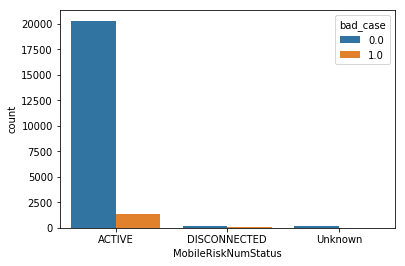

In [106]:
sns.countplot(df['MobileRiskNumStatus'], hue = df['bad_case'])

### MobileRiskPhoneType
This feature might be useful, although we can't really see any specific relationship with the values and bad cases. The decision tree might be able to find more useful relationships. 

In [107]:
df['MobileRiskPhoneType'].fillna(0, inplace = True)

In [108]:
df.bad_case.groupby(df.MobileRiskPhoneType).agg(['mean', 'count'])

,mean,count
MobileRiskPhoneType,,
0.0,0.027273,110
1.0,0.042929,1188
2.0,0.064010,20653
3.0,0.000000,1
5.0,0.117647,17
8.0,0.058824,34


### MobileRiskRegLocation
Sparse feature - we'll remove this. 

In [109]:
df.bad_case.groupby(df.MobileRiskRegLocation).agg(['mean', 'count'])

,mean,count
MobileRiskRegLocation,,
AU,1.000000,1
BB,0.000000,1
GB,0.062863,21889
RU,0.000000,2


In [110]:
cols_remove_2.append('MobileRiskRegLocation')

### MobileRiskScore
This could be a useful feature, but the values are not distributed well. We'll round the score to the nearest 100. 

In [111]:
df['MobileRiskScore'].fillna(0, inplace = True)

In [112]:
df.bad_case.groupby(df.MobileRiskScore).agg(['mean', 'count']).head()

,mean,count
MobileRiskScore,,
0.0,0.027273,110
11.0,0.142857,14
49.0,0.000000,1
251.0,0.062850,19634
252.0,0.050267,1313


### NumberofActiveCIFASRecords
This could be a useful feature - but we'll transform it to a new feature `ActiveCifasRecords` with a value of 1 or zero denoting if there are CIFAS records or not.

In [113]:
print('Count of NaNs: ',df['NumberofActiveCIFASRecords'].isna().sum())

Count of NaNs:  106


In [114]:
df.bad_case.groupby(df.NumberofActiveCIFASRecords).agg(['mean', 'count'])

,mean,count
NumberofActiveCIFASRecords,,
0.0,0.061189,21360
1.0,0.095238,63
2.0,0.049587,121
3.0,0.257576,66
4.0,0.138889,72
5.0,0.119048,42
6.0,0.051282,39
7.0,0.076923,13
8.0,0.171429,35


### NumberOfActivePaydayLoans
Sparse feature - we'll remove this.

In [115]:
df.bad_case.groupby(df.NumberOfActivePaydayLoans).agg(['mean', 'count'])

,mean,count
NumberOfActivePaydayLoans,,
0.0,0.062809,21844


In [116]:
cols_remove_2.append('NumberOfActivePaydayLoans')

### NumberofNoticesofCorrection
Sparse feature - we'll remove this too.

In [117]:
df.bad_case.groupby(df.NumberofNoticesofCorrection).agg(['mean', 'count'])

,mean,count
NumberofNoticesofCorrection,,
0.0,0.062852,21829
1.0,0.000000,3
2.0,0.000000,2
3.0,0.000000,8
4.0,0.000000,2


In [118]:
cols_remove_2.append('NumberofNoticesofCorrection')

### NumberofNoticesofDispute
Sparse feature - we'll remove this.

In [119]:
df.bad_case.groupby(df.NumberofNoticesofDispute).agg(['mean', 'count'])

,mean,count
NumberofNoticesofDispute,,
0.0,0.062818,21841
1.0,0.000000,2
2.0,0.000000,1


In [120]:
cols_remove_2.append('NumberofNoticesofDispute')

### OccupancyStatus
Looks like this feature could be really useful. We'll one-hot encode this. 

In [121]:
df.bad_case.groupby(df.OccupancyStatus).agg(['mean', 'count'])

,mean,count
OccupancyStatus,,
council,0.146366,1954
home_owner,0.031071,9945
joint_owner,0.023145,1469
living_with_parents,0.078743,2705
other,0.082474,388
tenant,0.091303,5542


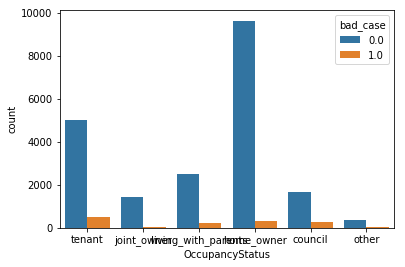

In [122]:
sns.countplot(df['OccupancyStatus'], hue = df['bad_case'])

### PepWarning
Sparse feature - we'll remove this.

In [123]:
print('Count of NaNs: ',df['PepWarning'].isna().sum())

Count of NaNs:  106


In [124]:
df.bad_case.groupby(df.PepWarning).agg(['mean', 'count'])

,mean,count
PepWarning,,
False,0.062964,21822
True,0.000000,75


In [125]:
cols_remove_2.append('PepWarning')

### PercentageOfTotalPayments
Sparse feature - we'll remove this.

In [126]:
print('Count of NaNs: ',df['PercentageOfTotalPayments'].isna().sum())

Count of NaNs:  17823


In [127]:
df.bad_case.groupby(df.PercentageOfTotalPayments).agg(['mean', 'count'])

,mean,count
PercentageOfTotalPayments,,
False,0.071121,4176
True,0.000000,4


In [128]:
cols_remove_2.append('PercentageOfTotalPayments')

### PrimaryChecksReturned
This could be a useful feature, maybe consider any rounding or general transforming though if prone to overfitting.

In [129]:
print('Count of NaNs: ',df['PrimaryChecksReturned'].isna().sum())

Count of NaNs:  114


In [130]:
df['PrimaryChecksReturned'].fillna(0, inplace = True)

In [131]:
df.bad_case.groupby(df.PrimaryChecksReturned).agg(['mean', 'count']).head()

,mean,count
PrimaryChecksReturned,,
0.0,0.056911,123
1.0,0.171687,332
2.0,0.107975,1417
3.0,0.085827,1771
4.0,0.067070,2147


### RatioOfIncomeChangeOverThreeMonths
Sparse feature - we'll remove this.

In [132]:
print('Count of NaNs: ',df['RatioOfIncomeChangeOverThreeMonths'].isna().sum())

Count of NaNs:  18263


In [133]:
cols_remove_2.append('RatioOfIncomeChangeOverThreeMonths')

### SanctionsWarning
Sparse feature - we'll remove this.

In [134]:
print('Count of NaNs: ',df['SanctionsWarning'].isna().sum())

Count of NaNs:  106


In [135]:
df.bad_case.groupby(df.SanctionsWarning).agg(['mean', 'count'])

,mean,count
SanctionsWarning,,
False,0.062720,21891
True,0.166667,6


In [136]:
cols_remove_2.append('SanctionsWarning')

### SDNWarning
Sparse feature - we'll remove this.

In [137]:
print('Count of NaNs: ',df['SDNWarning'].isna().sum())

Count of NaNs:  106


In [138]:
df.bad_case.groupby(df.SDNWarning).agg(['mean', 'count'])

,mean,count
SDNWarning,,
False,0.062706,21896
True,1.000000,1


In [139]:
cols_remove_2.append('SDNWarning')

### MerchantName
There are a lot of Merchants, and varying counts for each. We want to be able to capture some information here, but if we one-hot encode every Merchant this would definitely lead to over fitting (and be super inefficient computationally). 

Merchants like Adaptation Station LTD have high bad case rate, but only because there are 3 records in total. Simba Sleep on the other hand has a high bad case rate and a lot of records - we want to capture this distinction. 

I think for now let's just take a handful of the most active merchants to one-hot encode and leave the rest. We might want to come back to this feature, but between this one and the sector feature (which we need to add ourselves) most of the information should be captured. 

In [140]:
df.bad_case.groupby(df.MerchantName).agg(['mean', 'count']).sort_values(by=['count'], ascending=False).head(10)

,mean,count
MerchantName,,
SIMBA SLEEP LIMITED,0.072366,10516
PurpleBricks Payment Services,0.038771,1367
SPECIALISED TRAINING SERVICES LTD,0.092891,1055
EBS SYSTEMS LIMITED,0.106931,1010
OSC LIMITED T/A OPEN STUDY COLLEGE,0.024631,609
THE MOBILITY FURNITURE COMPANY LTD,0.055462,595
SHERMIN FINANCE LIMITED SMI,0.005464,549
EVE SLEEP PLC,0.013072,459
JUST PAINTBALL,0.067797,295


In [141]:
print('Number of Merchants: ',len(df.MerchantName.unique()))

Number of Merchants:  237


### Country
Sparse feature - get rid of this. 

In [142]:
df.bad_case.groupby(df.Country).agg(['mean', 'count'])

,mean,count
Country,,
GB,0.062719,22003


In [143]:
cols_remove_2.append('Country')

### Currency
Sparse feature - get rid of this.

In [144]:
df.bad_case.groupby(df.Currency).agg(['mean', 'count'])

,mean,count
Currency,,
GBP,0.062719,22003


In [145]:
cols_remove_2.append('Currency')

### CreatedAt
This could be a useful feature - we'll transform the datetime into an 'app_age' feature (minusing the CreatedDate from the Current Date).

We'll map to new features:
 - `day_of_week`
 - `is_weekend`
 - `day_of_month`
 - `day_of_year`
 - `month_of_year`
 - `year`
 - `absolute_time`
 - `hour_of_day`
 - `minute_of_day`

Other features we'll extract are:
 - `is_holiday`
 - `is_payday`

In [146]:
# Convert string to datetime obj
df['CreatedAt'] = pd.to_datetime(df['CreatedAt'], format='%Y-%m-%d %H:%M:%S')
df['CreatedDate'] = df['CreatedAt'].dt.date

### AcceptedAt
We'll extract a new feature called `days_between_create_accept` that shows the number of days between app creation and app acceptance. 

In [147]:
# Convert string to datetime obj
df['AcceptedAt'] = pd.to_datetime(df['AcceptedAt'], format = '%Y-%m-%d %H:%M:%S')

### Channel
We'll remove this feature in favour of the `ChannelType` feature.

In [148]:
df.bad_case.groupby(df.Channel).agg(['mean', 'count'])

,mean,count
Channel,,
ABC - Harley Street,0.000000,6
Aylesbury,0.000000,2
BH Solutions Ltd,0.000000,36
BMW,0.000000,196
Barking Store,0.000000,24
Basi Home Improvements Limited,0.000000,3
Bath Concessions,0.000000,2
Belfast Heating Services Ltd,0.000000,2
Bexleyheath Store,0.000000,23


In [149]:
cols_remove_2.append('Channel')

### ChannelType
We'll remove this.

In [ ]:
cols_remove_2.append('ChannelType')

### FinanceDescription
This is a complex feature to work with. For now we will extract into new features:
 - Term
 - BNPL
 - Interest Rate
 - Subsidised

In [152]:
# Just take the unique finance descriptions
finances = pd.Series(df['FinanceDescription'].unique()).sort_values().reset_index(drop=True)
print(str(len(finances)) + " unique finance descriptions")

144 unique finance descriptions


In [153]:
finances.values

array(['10 Months 0% APR', '10 Months Interest Free 0% APR',
       '11 Months 0% APR', '12 Mon Part Sub 14.9% APR',
       '12 Mon Part Sub 15.9% APR', '12 Mon Part Sub. 14.9% APR',
       '12 Mon Part Sub. 7.5% APR', '12 Mon Part Sub. 9.9% APR',
       '12 Month 0% APR', '12 Months 0% APR', '12 Months 14.9% APR',
       '12 Months 17.9% APR', '12 Months 19.5% APR',
       '12 Months 19.9% APR', '12 Months 29.9% APR', '12 Months 9.9% APR',
       '12 Months Interest Bearing  14.9% APR',
       '12 Months Interest Bearing  15.9% APR',
       '12 Months Interest Bearing  16.9% APR',
       '12 Months Interest Bearing  19.5% APR',
       '12 Months Interest Free  0% APR',
       '12 Months Interest Free 0% APR', '12 Months Part Sub 14.9% APR',
       '12 Months Part Subsidised 14.9% APR',
       '12 Months Part Subsidised 9.9% APR', '18 Months 0% APR',
       '18 Months 16.5% APR', '18 Months 19.5% APR',
       '18 Months Interest Bearing  15.9% APR',
       '18 Months Interest Free 0% A

### Lender
Sparse feature - we'll get rid of this.

In [155]:
cols_remove_2.append('Lender')

### CreditAmount
Obviously will be a useful feature. We'll log transform this for better performance.


`fcc_survey_df['Income_log'] = np.log((1+ fcc_survey_df['Income'])`

`income_log_mean = np.round(np.mean(fcc_survey_df['Income_log']), 2)`
`fig, ax = plt.subplots()
fcc_survey_df['Income_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(income_log_mean, color='r')
ax.set_title('Developer Income Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Developer Income (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(income_log_mean), fontsize=10)`

In [156]:
df['bad_case'].groupby(pd.qcut(df['CreditAmount'],5)).mean()

CreditAmount
(-0.001, 599.0]      0.062934
(599.0, 699.0]       0.059537
(699.0, 849.6]       0.045839
(849.6, 2000.0]      0.063113
(2000.0, 19800.0]    0.079027
Name: bad_case, dtype: float64

In [157]:
pd.qcut(df['CreditAmount'],5).value_counts()

(-0.001, 599.0]      5911
(849.6, 2000.0]      4484
(2000.0, 19800.0]    4315
(699.0, 849.6]       3665
(599.0, 699.0]       3628
Name: CreditAmount, dtype: int64

### DepositAmount
Another useful feature - we'll log transform this and also create a new feature of `depost_credit_ratio`

### DepositStatus
Not sure if this one is useful beyond the DepositAmount. We'll just extract a new feature called `no_deposit` to mark the ones where there was none. 

In [158]:
df.bad_case.groupby(df.DepositStatus).agg(['mean', 'count'])

,mean,count
DepositStatus,,
NO-DEPOSIT,0.066968,12185
PAID-BY-CARD,0.056638,8881
PAID-IN-STORE,0.145238,420
UNPAID,0.000000,125
UNPAID-COLLECT-MANUALLY,0.000000,167


### CustomerName

For this feature we will transform it to remove whitespace and punctuation. Then we'll extract a feature that shows the number of characters in the customer name. This may or may not prove useful...


In [159]:
print('Count of NaNs: ',df['CustomerName'].isna().sum())

Count of NaNs:  0


### DOB
We'll minus this date from the current date to create a new 'age' feature, then remove this one.

In [160]:
# Convert string to datetime obj
df['DOB'] = pd.to_datetime(df['DOB'], format='%Y-%m-%d')
df['DOB'] = df['DOB'].dt.date

### Email

Similar to CustomerName, we'll extract the length of the email address to a new feature. But first we will split the email address into name and domain. The length will be computed on the name part of the string, and we'll map the domain to another feature. 

In [161]:
print('Count of NaNs: ',df['Email'].isna().sum())

Count of NaNs:  0


### PhoneNumber
This feature doesn't tell us an awful lot - we'll get rid of it. 

In [162]:
df['PhoneNumber'].head(10)

0    +4407939009720
1    +4407972893075
2    +4407490389434
3    +4407446267192
4    +4407908169739
5    +4407780003191
6    +4407402732790
7    +4407553833162
8    +4407550388747
9     4407949751892
Name: PhoneNumber, dtype: object

In [163]:
cols_remove_2.append('PhoneNumber')

### BuildingNumber
We'll extract whether the record is numeric or not in an attempt to remove flat names, street names and errors then map all these records to 0, and adding a new feature `is_numeric_building_num` (this will also include NaNs). That way we have a numeric feature that might be useful. 

In [164]:
print('Count of NaNs: ',df['BuildingNumber'].isna().sum())

Count of NaNs:  2906


In [165]:
not_building_num_idx = [] # For the indexes of non numeric building numbers
not_building_num_val = [] # For the values of non numeric building numbers

for idx, val in enumerate(df['BuildingNumber']):
    try:
        if val.isnumeric():
            continue
        else:
            not_building_num_idx.append(idx)
            not_building_num_val.append(val)
    except:
        not_building_num_idx.append(idx)
        not_building_num_val.append(val)

print('Number of non-numeric Building Numbers: ',len(not_building_num_val))
print(not_building_num_val[45:55])

Number of non-numeric Building Numbers:  2979
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [166]:
print('Non-numerical building numbers')
df.iloc[not_building_num_idx].bad_case.agg(['mean', 'count'])

Non-numerical building numbers


mean        0.068479
count    2979.000000
Name: bad_case, dtype: float64

In [167]:
print('Numerical building numbers')
not_building_num_df = df.index.isin(not_building_num_idx)
df[~not_building_num_df].bad_case.agg(['mean', 'count'])

Numerical building numbers


mean         0.061817
count    19024.000000
Name: bad_case, dtype: float64

### Street
We'll get rid of this feature in favour of a looked up region feature.

In [168]:
cols_remove_2.append('Street')

### City
We'll get rid of this feature in favour of a looked up region feature.

In [169]:
cols_remove_2.append('City')

### Postcode
We map the geographies to region instead so we can prevent overfitting. WE'll then one-hot encode the region.

In [170]:
pcd_lookup = pd.read_csv('input/pcd_lookup.csv')

In [171]:
pcd_lookup.head()

,pcd_no_space,reg_name
0,CA67BB,North East
1,CA67BD,North East
2,CA67BE,North East
3,CA67BG,North East
4,CA67BH,North East


In [172]:
df['Postcode'] = df.Postcode.str.replace(' ', '') # Remove whitespace from Postcode for lookup
df.rename(columns = {'Postcode':'pcd_no_space'}, inplace=True)

df = df.merge(pcd_lookup, 'left')

In [173]:
df['reg_name'].fillna('Unknown', inplace = True)

In [174]:
df.bad_case.groupby(df.reg_name).agg(['mean', 'count'])

,mean,count
reg_name,,
East Midlands,0.055917,1538
East of England,0.060914,1970
London,0.095408,3354
North East,0.058677,801
North West,0.057131,2363
Northern Ireland,0.035556,675
Scotland,0.084068,1701
South East,0.045777,3102
South West,0.043659,1924


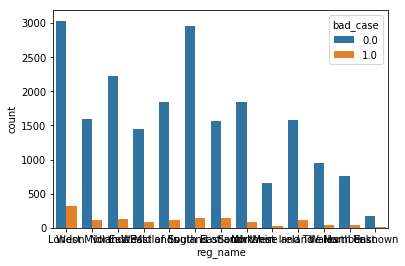

In [175]:
sns.countplot(df['reg_name'], hue = df['bad_case'])

In [176]:
cols_remove_2.append('pcd_no_space')

### IsDuplicated
Sparse feature - we'll get rid of this.

In [177]:
df.bad_case.groupby(df.IsDuplicated).agg(['mean', 'count'])

,mean,count
IsDuplicated,,
0,0.063385,20478
1,0.000000,2
4,0.400000,5
11,0.000000,8
16,0.075949,158
21,0.089286,56
32,0.094891,137
38,0.105263,19
48,0.000000,4


In [178]:
cols_remove_2.append('IsDuplicated')

### Multi-Tier
We don't have to change this variable.

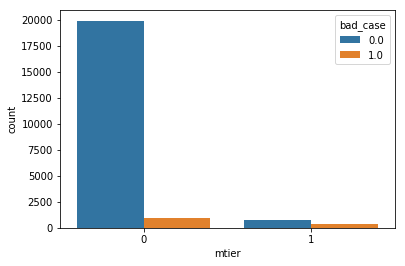

In [179]:
sns.countplot(df['mtier'], hue = df['bad_case'])

# Feature Engineering
Having done our cursory exploration of the variables, we now have a pretty good idea of how we want to transform our variables in preparation for our final dataset. We will perform our feature engineering through a series of helper functions that each serve a specific purpose.

We'll begin by removing the columns we found were not helpful to our algorithm. 

In [180]:
# Remove columns
df = df.drop(cols_remove_2, 1)

In [181]:
# BankruptcyInformationAssociate
    
def transform_bankruptcy_information_associate(df):
    """"
    Map BankruptcyInformationAssociate feature so shows 2 if 
    there are Bancrupcies, 1 if Unknown and 0 if there are none.
    Then remove original BankruptcyInformationAssociate feature.
    """
    df['is_bankruptcy_information_associate'] = df['BankruptcyInformationAssociate'].apply(lambda x: 2 if x > 0 else(0 if x == 0 else 1))
    df = df.drop('BankruptcyInformationAssociate', 1)
    return df

In [182]:
# ConfirmatoryDobs

def transform_confirmatory_dobs(df):
    """
    Map ConfirmatoryDobs feature so shows 1 if is a 
    null record, and 0 if not. Then map NaNs to 0.
    """
    df['is_null_confirmatory_dobs'] = df['ConfirmatoryDobs'].apply(lambda x: 1 if pd.isnull(x) else 0)
    df['ConfirmatoryDobs'].fillna(0, inplace = True)
    return df

In [183]:
# CreditScore

def transform_credit_score(df):
    """"
    Log transform credit score, then remove original 
    CreditScore feature.
    """
    df['log_credit_score'] = np.log((1+ df['CreditScore']))
    df['log_credit_score'].fillna(2.8, inplace = True)
    df = df.drop('CreditScore', 1)
    return df

In [184]:
# EmailDomainStatusIsActive

def transform_email_domain_status_is_active(df):
    """
    Map EmailDomainStatusIsActive to 2 if Active, 
    1 if Unknown and 0 if Inactive.
    """
    df['EmailDomainStatusIsActive'] = df['EmailDomainStatusIsActive'].apply(lambda x: 2 if x == 'Active' else(1 if x == 'Unknown' else 0))
    return df

In [185]:
# EmailStatusisActive

def transform_email_status_is_active(df):
    """
    Map EmailStatusisActive to 2 if Active, 1
    if Unknown and 0 if Inactive.
    """
    df['EmailStatusisActive'] = df['EmailStatusisActive'].apply(lambda x: 2 if x == 'Active' else(1 if x == 'Unknown' else 0))
    return df

In [186]:
# EmailageScore

def impute_emailage_score(df):
    """
    Create null flag feature for EmailageScore. 
    Divide EmailageScore by 10 and round.
    Impute null values using the median.
    """
    df['is_null_emailage_score'] = df['EmailageScore'].apply(lambda x: 1 if pd.isnull(x) else 0)
    df['EmailageScore'] = round(df['EmailageScore'] / 10, 1)
    df['EmailageScore'].fillna(df['EmailageScore'].median(), inplace = True)
    return df

In [187]:
# GrossIncome

def transform_gross_income(df):
    """
    Log transform GrossIncome. Then impute null
    values using the median, remove GrossIncome.
    """
    df['log_gross_income'] = np.log((1+ df['GrossIncome']))
    df['log_gross_income'].fillna( np.log((df['GrossIncome'].median())), inplace = True)
    df = df.drop('GrossIncome', 1)
    return df

In [188]:
# IPAddress

def is_ip_validated(df):
    """
    Map records to show 1 if IP address is
    validated and 0 if not. Remove IPAddress feature.
    """
    df['is_ip_validated'] = pd.Series(df.index.values).apply(lambda x: 1 if x in non_validated_idx else 0)
    df = df.drop('IPAddress', 1)
    return df

In [189]:
# MobileRiskNumStatus

def transform_mobile_risk_num_status(df):
    """
    Map MobileRiskNumStatus to show 2 if Active, 
    1 if Unknown and 0 if Inactive.
    """
    df['MobileRiskNumStatus'] = df['MobileRiskNumStatus'].apply(lambda x: 2 if x == 'Active' else(1 if x == 'Unknown' else 0))
    return df

In [190]:
# MobileRiskScore

def transform_mobile_risk_score(df):
    """
    Divide MobileRiskScore by 100 and round.
    """
    df['MobileRiskScore'] = round(df['MobileRiskScore'] / 100)
    return df

In [191]:
# NumberofActiveCIFASRecords

def transform_is_active_cifas(df):
    """
    Map NumberofActiveCIFASRecords to show 1 if
    there are active Cifas records and 0 if there
    aren't. Also map another feature that shows 1
    if the NumberofActiveCIFASRecords was originally null.
    """
    df['is_null_number_of_active_cifas'] = df['NumberofActiveCIFASRecords'].apply(lambda x: 1 if pd.isnull(x) else 0)
    df['is_active_cifas'] = df['NumberofActiveCIFASRecords'].apply(lambda x: 1 if x > 0 else 0)
    df['NumberofActiveCIFASRecords'].fillna(0, inplace = True)
    return df

In [192]:
# MerchantName

top_merchants = pd.Series(df['MerchantName'].value_counts().head(10).index.values)

def is_top_merchant(df): 
    """
    Creates individaul encoded features for each
    of the 10 most active merchants. Then maps all
    records to a is_top_ten_merchant feature.
    """
    df['is_top_10_merchant'] = df['MerchantName'].apply(lambda x: 1 if x in top_merchants else 0)
    df = df.drop('MerchantName', 1)
    return df

In [193]:
# CreatedAt

def calculate_app_age(df):
    """
    
    """
    today = date.today()
    #df['app_age'] = df['CreatedDate'].apply(lambda x: today - x).astype(str).str[:-24].astype(float)
    
    df['day_of_week'] = df['CreatedAt'].dt.dayofweek
    df['is_weekend'] = df['CreatedAt'].dt.dayofweek.apply(lambda x: 1 if x > 4 else 0)
    df['day_of_month'] = df['CreatedAt'].dt.day
    #df['day_of_year'] = df['CreatedAt'].dt.dayofyear
    #df['month_of_year'] = df['CreatedAt'].dt.month
    #df['year'] = df['CreatedAt'].dt.year
    df['hour_of_day'] = df['CreatedAt'].dt.hour
    df['minute_of_day'] = df['CreatedAt'].dt.minute
    
    bmonth_ends = pd.Series(df['CreatedAt'].apply(lambda x: BMonthEnd().rollforward(x)))
    df['is_payday'] = df['CreatedDate'].apply(lambda x: 1 if x in bmonth_ends else 0)
    
    df = df.drop(['CreatedDate'], 1)
    return df

In [194]:
# AcceptedAt

def calculate_time_accept_create(df):
    """
    
    """
    df['time_between_accept_create'] = df['AcceptedAt'].apply(lambda x: time.mktime(x.timetuple())) - df['CreatedAt'].apply(lambda x: time.mktime(x.timetuple()))
    df['log_time_between_accept_create'] = np.log((1 + df['time_between_accept_create']))
    df['log_time_between_accept_create'].fillna( np.log((df['time_between_accept_create'].median())), inplace = True)
    df = df.drop(['AcceptedAt', 'CreatedAt', 'time_between_accept_create'], 1)
    return df

In [195]:
# FinanceDescription

def transform_finance_decription(df):
    """
    Extract Interest Rate, Term, Subsidised, and BNPL
    from string into new features.
    """
    # Remove BNPL
    df = df[~df['FinanceDescription'].str.contains("BNPL")]
    
    def extract_term(df):
        """
        Extract the loan term from string
        """
        term = []
        for i in df['FinanceDescription']:
            if i.split(' Mon', 1)[0][-2:] == 'PR':
                term.append(float(i.split(' 18', 1)[0][-2:]))
            elif (len(i.replace(" ", "").split('Mon')[0]) == 7 and '+' in i):
                term.append(float(i.replace(" ", "")[4:5]) + float(i.replace(" ", "")[6:7]))
                
            elif (len(i.replace(" ", "").split('Mon')[0]) == 8 and '+' in i):    
                term.append(float(i.replace(" ", "")[4:5]) + float(i.replace(" ", "")[6:8]))
                
            elif (len(i.replace(" ", "").split('Mon')[0]) == 9 and '+' in i):    
                term.append(float(i.replace(" ", "")[4:6]) + float(i.replace(" ", "")[7:9]))
                
            else:
                term.append(float(i.split(' Mon', 1)[0][-2:]))
        return term
    df['term'] = extract_term(df)
    
    def extract_apr(df):
        """
        Extract the interest from string
        """
        apr = []
        for i in df['FinanceDescription']:
            if " 0%" in i:
                apr.append(float(0))
            elif "s " in i.split('%', 1)[0][-4:]:
                apr.append(float(i.split('%', 1)[0][-2:]))
            elif "nths" in i.split('%', 1)[0][-4:]:
                # Missing BNPL APRs are replaced with the BNPL APR mean
                apr.append(float(sum([20.9,18.9,16.9])/len([20.9,18.9,16.9])))
            else:
                apr.append(float((i.split('%', 1)[0][-4:])))
        return apr
    df['apr'] = extract_apr(df)
    
    def extract_subsidised(df):
        """
        Extract whether the finance is 
        subsidised from string
        """
        is_subsidised_list = []
        for i in df['FinanceDescription']:
            if "Sub" in i:
                is_subsidised_list.append(1)
            elif "sub" in i:
                is_subsidised_list.append(1)
            else:
                is_subsidised_list.append(0)
        return is_subsidised_list
    df['is_subsidised'] = extract_subsidised(df)
    
    df = df.drop(['FinanceDescription'], 1)
    
    return df

In [196]:
# CreditAmount

def credit_amount_transform(df):
    """
    
    """
    df['log_credit_amount'] = np.log((1+ df['CreditAmount']))
    df['log_credit_amount'].fillna(2.8, inplace = True)
    return df

In [197]:
# DepositAmount

def transform_deposit_amount(df):
    """
    
    """
    df['log_deposit_amount'] = np.log((1+ df['DepositAmount']))
    df['log_deposit_amount'].fillna( np.log((df['DepositAmount'].median())), inplace = True)
    df['deposit_credit_ratio'] = df['DepositAmount'] / df['CreditAmount']
    df = df.drop('DepositAmount', 1)
    return df

In [198]:
# DepositStatus

def is_no_depoist(df):
    """
    
    """
    df['is_no_deposit'] = df['DepositStatus'].apply(lambda x: 1 if x == 'NO-DEPOSIT' else 0)
    df = df.drop('DepositStatus', 1)
    return df

In [199]:
# CustomerName

def calculate_name_len(df):
    """
    
    """
    df['customer_name_len'] = df['CustomerName'].apply(lambda x: len(x))
    df = df.drop('CustomerName', 1)
    return df

In [200]:
# DOB

def calculate_customer_age(df):
    """
    
    """
    today = date.today()
    df['customer_age'] = df['DOB'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
    df = df.drop('DOB', 1)
    return df

In [201]:
# Email

def calculate_email_len(df):
    """
    
    """
    df['email_name_len'] = df['Email'].apply(lambda x: len(x.split('@', 1)[0]))
    df = df.drop('Email', 1)
    return df

In [202]:
# BuildingNumber

def is_building_name_numerical(df):
    """
    
    """
    df['BuildingNumber'] = df['BuildingNumber'].apply(lambda x: 0 if x in not_building_num_val else x).astype('float')
    return df

In [203]:
def dummies(df, columns = ['EmploymentStatus', 'Gender', 'HasCCJ', 'OccupancyStatus', 'ChannelType', 'reg_name']):
    for column in columns:
        df[column] = df[column].apply(lambda x: str(x))
        df = pd.concat((df, pd.get_dummies(df[column], prefix = column)), axis = 1)
        del df[column]
    return df

Having built our helper functions, we can now execute them in order to build our dataset that will be used in the model

In [204]:
df = transform_bankruptcy_information_associate(df)
df = transform_confirmatory_dobs(df)
df = transform_credit_score(df)
df = transform_email_domain_status_is_active(df)
df = transform_email_status_is_active(df)
df = impute_emailage_score(df)
df = transform_gross_income(df)
df = is_ip_validated(df)
df = transform_mobile_risk_num_status(df)
df = transform_mobile_risk_score(df)
df = transform_is_active_cifas(df)
df = is_top_merchant(df)
df = calculate_app_age(df)
df = calculate_time_accept_create(df)
df = transform_finance_decription(df)
df = credit_amount_transform(df)
df = transform_deposit_amount(df)
df = is_no_depoist(df)
df = calculate_name_len(df)
df = calculate_customer_age(df)
df = calculate_email_len(df)
df = is_building_name_numerical(df)
df = dummies(df)

C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

We can see that our final dataset has 91 columns, composed of our target column and 90 predictor variables. Although highly dimensional datasets can result in high variance, I think we should be fine here.

In [205]:
print('Number of columns: ', len(df.columns))
print('Number of records: ', len(df))

Number of columns:  78
Number of records:  21430


## Feature Selection & Sampling
We will employ two sampling techniques. The first will be undersampling good cases.

The second methodology will be Synthetic Minority Oversampling Technique (SMOTE). SMOTE uses a K-Nearest Neighbour algorithm to synthetically add new data to an imbalanced dataset. We'll try this method to correct our dataset and hope that it helps the recall value.

In [206]:
df_undersample = df.drop(df.query('bad_case == 0').sample(frac=.70).index)

In [207]:
X = df.loc[:, df.columns != 'bad_case']
y = df[['bad_case']] 

In [208]:
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

In [209]:
for i in X.columns:
    #print('Categorical: ',i)
    X[i] = rank_gauss(X[i].values)

C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)
gc.collect()

0

In [211]:
sm = SMOTE(random_state = 12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

C:\Users\Edward Sims\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Edward Sims\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [212]:
print("Before SMOTE:")
print("---------------------")
print("X_train: " + str(len(X_train)) + " records")
print("y_train: " + str(len(y_train)) + " records")
print("X_test: " + str(len(X_test)) + " records")
print("y_test: " + str(len(y_test)) + " records")

Before SMOTE:
---------------------
X_train: 15001 records
y_train: 15001 records
X_test: 6429 records
y_test: 6429 records


In [213]:
print("After SMOTE:")
print("---------------------")
print("X_train: " + str(len(X_train_res)) + " records")
print("y_train: " + str(len(y_train_res)) + " records")
print("X_test: " + str(len(X_test)) + " records")
print("y_test: " + str(len(y_test)) + " records")

After SMOTE:
---------------------
X_train: 28054 records
y_train: 28054 records
X_test: 6429 records
y_test: 6429 records


## Hyperparameter Tuning

We will use grid search to identify the optimal parameters of our random forest model. On my Windows 8GB machine, the process took quite a while so should consider upgrading to Azure computing. 

In [214]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
from keras.callbacks import Callback
import logging

Using TensorFlow backend.


In [215]:
class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_proba(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        
        logging.info("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, score))
        print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, score))
        logs['val_auc'] = score

In [216]:
n_folds = 10
folds = KFold(n_splits=n_folds, shuffle=True, random_state=42)
sub_preds = np.zeros(X_test.shape[0])
oof_preds = np.zeros(X_train_res.shape[0])

In [218]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train_res)):
    trn_x, trn_y = X_train_res[trn_idx], y_train_res[trn_idx]
    val_x, val_y = X_train_res[val_idx], y_train_res[val_idx]
    earlystop = EarlyStopping(monitor='val_auc', min_delta=0, patience=3, verbose=0, mode='max')
    file_path = "fold " + str(n_fold+1) + " best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_auc", verbose = 1, save_best_only = True, mode = "max")    
    print( 'Setting up neural network...' )
    nn = Sequential()
    nn.add(Dense(units = 400 , kernel_initializer = 'normal', input_dim = X_train_res.shape[1]))
    nn.add(PReLU())
    nn.add(Dropout(.5))
    nn.add(Dense(units = 160 , kernel_initializer = 'normal'))
    nn.add(PReLU())
    nn.add(BatchNormalization())
    nn.add(Dropout(.5))
    nn.add(Dense(units = 64 , kernel_initializer = 'normal'))
    nn.add(PReLU())
    nn.add(BatchNormalization())
    nn.add(Dropout(.5))
    nn.add(Dense(units = 26, kernel_initializer = 'normal'))
    nn.add(PReLU())
    nn.add(BatchNormalization())
    nn.add(Dropout(.5))
    nn.add(Dense(units = 12, kernel_initializer = 'normal'))
    nn.add(PReLU())
    nn.add(BatchNormalization())
    nn.add(Dropout(.5))
    nn.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer='adam')
    
    print( 'Fitting neural network...' )
    ival = IntervalEvaluation(validation_data=(val_x, val_y), interval=10)
    nn.fit(trn_x, trn_y, validation_data = (val_x, val_y), epochs=20, verbose=0, callbacks=[ival, earlystop, check_point], batch_size=128)
    
    best_model = load_model(file_path)
    
    oof_preds[val_idx] = best_model.predict(val_x).flatten()
    
    print(roc_auc_score(val_y, oof_preds[val_idx]))
    
    
    print( 'Predicting...' )
    sub_preds += best_model.predict(X_test).flatten().clip(0,1) / folds.n_splits
    
    gc.collect()
print('FULL AUC: {}'.format(roc_auc_score(y_train_res, oof_preds)))

Setting up neural network...
Fitting neural network...
Instructions for updating:
Use tf.cast instead.
interval evaluation - epoch: 0 - score: 0.903409

Epoch 00001: val_auc improved from -inf to 0.90341, saving model to fold 1 best_model.hdf5
interval evaluation - epoch: 1 - score: 0.925549

Epoch 00002: val_auc improved from 0.90341 to 0.92555, saving model to fold 1 best_model.hdf5
interval evaluation - epoch: 2 - score: 0.947660

Epoch 00003: val_auc improved from 0.92555 to 0.94766, saving model to fold 1 best_model.hdf5
interval evaluation - epoch: 3 - score: 0.961959

Epoch 00004: val_auc improved from 0.94766 to 0.96196, saving model to fold 1 best_model.hdf5
interval evaluation - epoch: 4 - score: 0.969892

Epoch 00005: val_auc improved from 0.96196 to 0.96989, saving model to fold 1 best_model.hdf5
interval evaluation - epoch: 5 - score: 0.972323

Epoch 00006: val_auc improved from 0.96989 to 0.97232, saving model to fold 1 best_model.hdf5
interval evaluation - epoch: 6 - sco

interval evaluation - epoch: 18 - score: 0.994847

Epoch 00019: val_auc improved from 0.99214 to 0.99485, saving model to fold 3 best_model.hdf5
interval evaluation - epoch: 19 - score: 0.994111

Epoch 00020: val_auc did not improve from 0.99485
0.9948470839260314
Predicting...
Setting up neural network...
Fitting neural network...
interval evaluation - epoch: 0 - score: 0.900091

Epoch 00001: val_auc improved from -inf to 0.90009, saving model to fold 4 best_model.hdf5
interval evaluation - epoch: 1 - score: 0.941270

Epoch 00002: val_auc improved from 0.90009 to 0.94127, saving model to fold 4 best_model.hdf5
interval evaluation - epoch: 2 - score: 0.953370

Epoch 00003: val_auc improved from 0.94127 to 0.95337, saving model to fold 4 best_model.hdf5
interval evaluation - epoch: 3 - score: 0.957103

Epoch 00004: val_auc improved from 0.95337 to 0.95710, saving model to fold 4 best_model.hdf5
interval evaluation - epoch: 4 - score: 0.977002

Epoch 00005: val_auc improved from 0.95710 

interval evaluation - epoch: 17 - score: 0.993796

Epoch 00018: val_auc did not improve from 0.99404
interval evaluation - epoch: 18 - score: 0.994669

Epoch 00019: val_auc improved from 0.99404 to 0.99467, saving model to fold 6 best_model.hdf5
interval evaluation - epoch: 19 - score: 0.995214

Epoch 00020: val_auc improved from 0.99467 to 0.99521, saving model to fold 6 best_model.hdf5
0.9952144815188391
Predicting...
Setting up neural network...
Fitting neural network...
interval evaluation - epoch: 0 - score: 0.908511

Epoch 00001: val_auc improved from -inf to 0.90851, saving model to fold 7 best_model.hdf5
interval evaluation - epoch: 1 - score: 0.933293

Epoch 00002: val_auc improved from 0.90851 to 0.93329, saving model to fold 7 best_model.hdf5
interval evaluation - epoch: 2 - score: 0.946217

Epoch 00003: val_auc improved from 0.93329 to 0.94622, saving model to fold 7 best_model.hdf5
interval evaluation - epoch: 3 - score: 0.959829

Epoch 00004: val_auc improved from 0.94622

interval evaluation - epoch: 15 - score: 0.992452

Epoch 00016: val_auc did not improve from 0.99312
interval evaluation - epoch: 16 - score: 0.993882

Epoch 00017: val_auc improved from 0.99312 to 0.99388, saving model to fold 9 best_model.hdf5
interval evaluation - epoch: 17 - score: 0.992942

Epoch 00018: val_auc did not improve from 0.99388
interval evaluation - epoch: 18 - score: 0.993723

Epoch 00019: val_auc did not improve from 0.99388
interval evaluation - epoch: 19 - score: 0.993863

Epoch 00020: val_auc did not improve from 0.99388
0.9938823126833803
Predicting...
Setting up neural network...
Fitting neural network...
interval evaluation - epoch: 0 - score: 0.902669

Epoch 00001: val_auc improved from -inf to 0.90267, saving model to fold 10 best_model.hdf5
interval evaluation - epoch: 1 - score: 0.937261

Epoch 00002: val_auc improved from 0.90267 to 0.93726, saving model to fold 10 best_model.hdf5
interval evaluation - epoch: 2 - score: 0.953607

Epoch 00003: val_auc impro

In [230]:
y_pred_train = best_model.predict(X_train_res).flatten().round()
y_true_train = y_train_res

print("###########################")
print("#### Training Results ####")
print("###########################")
print("")

print('Accuracy score', accuracy_score(y_true_train, y_pred_train))
print('Precision score: ', precision_score(y_true_train, y_pred_train))
print('Recall score: ', recall_score(y_true_train, y_pred_train))

###########################
#### Training Results ####
###########################

Accuracy score 0.9820702930063449
Precision score:  0.9665378777425141
Recall score:  0.9987167605332573


NameError: name 'rf' is not defined

Let's take a brief look at our variable importance according to our random forest model. We can see that some of the original columns we predicted would be important in fact were, including gender, fare, and age. But we also see title, name length, and ticket length feature prominently, so we can pat ourselves on the back for creating such useful variables.

In [ ]:
# Plot Confusion Matrix - VALIDATION RESULTS
def plot_confusion_matrix(y_true_test, y_pred_test, classes,
                          normalize = False,
                          title = None,
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_train, y_pred_crossval)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true_train, y_pred_crossval)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels = classes, yticklabels = classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print(classes)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train_res, y_pred_crossval, classes=y_true_train,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train_res, y_pred_crossval, classes=y_true_train, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
y_scores_crossval = gs.predict_proba(X_train_res)[:, 1]

In [ ]:
# Plot ROC-AUC curve
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
fpr, tpr, auc_thresholds = roc_curve(y_true_train, y_scores_crossval)
#print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

## Final Results (Test Set)

In [231]:
y_pred_test = best_model.predict(X_test).flatten().round()
y_true_test = y_test

In [ ]:
# Save results
df.to_csv('rf_dataset_final.csv', index=False)

rf_results_final = pd.concat([X_test.reset_index(drop = True),
                              pd.DataFrame(y_pred_test, columns = ['bad_case_pred']),
                              pd.DataFrame(y_true_test.values, columns = ['bad_case_true'])],
                             axis = 1)
pd.DataFrame.to_csv(rf_results_final, 'rf_results_final.csv', index = False)

feature_importances_final = pd.concat((pd.DataFrame(X_test.columns, columns = ['variable']), 
                                           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
                                          axis = 1).sort_values(by = 'importance', ascending = False)
pd.DataFrame.to_csv(feature_importances_final, 'feature_importances_final.csv', index = False)

Confusion matrix, without normalization
[[5527  496]
 [ 242  164]]
[0. 1.]
Normalized confusion matrix
[[0.92 0.08]
 [0.6  0.4 ]]
[0. 1.]


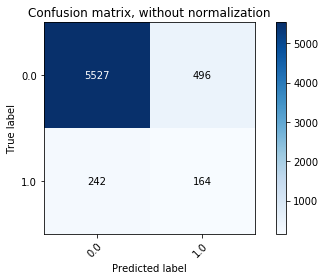

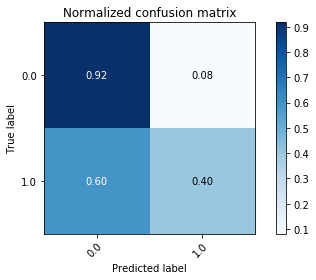

In [232]:
# Plot Confusion Matrix - TEST RESULTS
def plot_confusion_matrix(y_true_test, y_pred_test, classes,
                          normalize = False,
                          title = None,
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true_test, y_pred_test)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels = classes, yticklabels = classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print(classes)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_test, classes=y_true_test,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_test, classes=y_true_test, normalize=True,
                      title='Normalized confusion matrix')

In [233]:
print("###########################")
print("#### Testing Results ####")
print("###########################")
print("")

print('Accuracy score', accuracy_score(y_true_test, y_pred_test))
print('Precision score: ', precision_score(y_true_test, y_pred_test))
print('Recall score: ', recall_score(y_true_test, y_pred_test))

###########################
#### Testing Results ####
###########################

Accuracy score 0.8852076528231452
Precision score:  0.24848484848484848
Recall score:  0.4039408866995074


NameError: name 'rf' is not defined

In [ ]:
# Find the correlation coefficients and list alongside the feature importance. Export .csv
corr = pd.DataFrame(df.corr().loc[:,'bad_case'].to_frame()).reset_index()
corr.columns = ['variable', 'corr']

feature_importances_final.merge(corr).to_csv('feature_importances_final_with_corr.csv')

In [ ]:
# Display feature importances with correlations 
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])),
          axis = 1).sort_values(by='importance', ascending = False)[:20]

## Conclusion
Between the two models we ran, our accuracy stayed the same at ~95% each time (before and after feature engineering). Our Recall score did improve after feature engineering, but only by ~2% on the test data.

Next steps would be to hand pick the features a little more (maybe limit them), and to eventually try out different models. 